In [105]:
from support.common.connect.connect_db.ConnectDB import localhost_query
from support.common.connect.connect_db.ConnectDB import DBinfo
import pymysql
import pandas as pd 
import numpy
import re
import matplotlib.pyplot as plt #绘图
from matplotlib.font_manager import FontProperties
import matplotlib as mpl #配置字体
import seaborn as sns
from pyecharts import Bar,Line,Pie,Style,Scatter,Boxplot

DBdict = DBinfo.DBDict

In [97]:
# 发布职位总量和职位分布
all_position_sql = "select jobs_neitui_position_name_detail as 'position',count(1) as 'position_count',sum(jobs_neitui_position_numbers) as 'numbers' from jobs_neitui_position group by jobs_neitui_position_name_detail"
all_position = pd.read_sql(all_position_sql,con=pymysql.connect(**DBdict['local'])).sort_values(by='numbers',ascending=False)

attr = all_position['position']
v1 = all_position['numbers']
bar = Bar("职业和在招人数","oppo的50人移动开发，折算为5人")
bar.add("人数", attr, v1, is_stack=True, is_label_show=True, xaxis_interval=0, xaxis_rotate=30, yaxis_rotate=30)
bar

In [11]:
all_info_sql = "select * from jobs_neitui_position inner join jobs_neitui_info on jobs_neitui_info_positionid = jobs_neitui_position_id"
all_info = pd.read_sql(all_info_sql,con=pymysql.connect(**DBdict['local']))

In [98]:
# 行业、融资情况、学历、工作年限
pie_info = all_info[['jobs_neitui_position_industryTypeName','jobs_neitui_position_financeTypeName','jobs_neitui_position_qualificationsName','jobs_neitui_position_workExperienceName']]

# 本来说循环遍历生成4个图，但效果不佳
# pie_name = {'jobs_neitui_position_industryTypeName':"行业",'jobs_neitui_position_financeTypeName':"融资情况",'jobs_neitui_position_qualificationsName':"学历要求",'jobs_neitui_position_workExperienceName':"工作年限要求"}

industry_pip = Pie("行业",title_pos='center')
style = Style()
pie_style = style.add(is_label_show=True,label_text_color=None)
industry = pie_info.groupby('jobs_neitui_position_industryTypeName').size()
industry = industry.reset_index(name='count')
industry.columns = ['industry','count']
industry_pip.add("行业",industry['industry'],industry['count'],center=[30,60], radius=[0,55],is_legend_show=False,**pie_style)
industry_pip

In [135]:
# 薪资情况
line_info = all_info[['jobs_neitui_position_salaryRangeName_low','jobs_neitui_position_salaryRangeName_high','jobs_neitui_position_qualificationsName']]
salary_low = line_info.groupby('jobs_neitui_position_salaryRangeName_low').size()
salary_low = salary_low.reset_index(name='count')
salary_low.columns = ['salary','count']
salary_high = line_info.groupby('jobs_neitui_position_salaryRangeName_high').size()
salary_high = salary_high.reset_index(name='count')
salary_high.columns = ['salary','count']


# 合并并填充0值（因为echart多折线图只会显示每条折线共有的x坐标，如果某条线的x坐标确实，则其他的折线也会剔除数据，故作特殊处理
salary = pd.DataFrame({'salary':[0, 8, 10, 11, 12, 13, 15, 17, 18, 20, 25, 29, 30, 35, 40, 50, 60]})
salary_low = pd.merge(salary,salary_low,on=["salary"],how='outer').fillna(value=0)
salary_high = pd.merge(salary,salary_high,on=["salary"],how='outer').fillna(value=0)

salary_line = Line("薪水分布","0表示面议薪资")
salary_line.add("low", x_axis=salary["salary"], y_axis=salary_low["count"],is_smooth=True,is_fill=True,line_opacity=0.2,area_opacity=0.4)
salary_line.add("high", x_axis=salary["salary"], y_axis=salary_high["count"],is_smooth=True,is_fill=True,area_color="#000",area_opacity=0.3)
salary_line

[('经验', 14), ('开发', 11), ('技术', 6), ('产品', 6), ('应用', 6), ('精通', 6), ('Web', 5), ('架构', 5), ('能力', 5), ('网络', 5)]


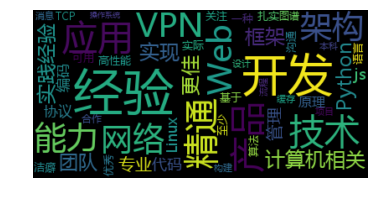

In [158]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from support.common.connect.connect_db.ConnectDB import localhost_query
import jieba

#work_duty = "充分参与整个开发流程，从制定测试计划到产品上线最后一道关卡的把控，在此基础上，配合相关人员，提供针对于产品结构及功能的指导意见主要参与测试app和we应用/对新鲜事物有兴趣且能够踏下心来去做，在有资源有条件的情况下，愿意接触自动化测试/"
#work_requirement = "熟悉黑白盒测试的流程及过程管理，（编写测试用例 bug跟踪 搭建测试环境 编写缺陷等）/实际项目中用过至少二种较为流行的自动化测试工具，如Selenium/熟悉linux，能够编写基本的shell脚本/熟悉基本的网络协议，对udp，tcp协议有基础的理解，对应用层的协议有基本理解/熟悉SQL及常用数据库，如nosql：redis，mongo对批量导入测试数据，或者编写测试数据脚本有过了解/知悉如何使用jmeter（RoadRunner）进行性能方面的测试/年以上web测试经验，年以上app测试经验/熟练掌握Docker，jenkins以及公有云的使用者优先/"

def create_wordcloud(info,stopwords_list):
    wordlist = jieba.cut(info,cut_all=False,HMM=False)  # 采用精确模式
    # 设置停止词
    stopwords = set('')
    stopwords.update(stopwords_list)
    text = " ".join(wordlist)

    wordcloud = WordCloud(
        width=400,
        height=200,
        background_color = "black", # 背景颜色
        max_words = 50, # 最多词个数
        stopwords = stopwords, #设置停用词
        font_path = "/Users/wangyuxiang/Library/Fonts/msyh.ttf", # 中文字体
        max_font_size = 60,  # 字体最大值
        random_state = 30, # 配色方案

    ).generate(text)

    process_word = WordCloud.process_text(wordcloud,text)

    # 获取文本词频最高的前10个词
    sort = sorted(process_word.items(),key=lambda e:e[1],reverse=True)
    print(sort[:10])
   
    # 存储和展示
    wordcloud.to_file('cloud.jpg')
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()


if __name__ == '__main__':
    wordcloud_info = all_info[['jobs_neitui_position_salaryRangeName_low','jobs_neitui_position_state','jobs_neitui_info_work_duty','jobs_neitui_info_work_requirement']]      
    
    # 剔除英文介绍的数据
    position_wordcloud = wordcloud_info.loc[(wordcloud_info['jobs_neitui_position_state']=='ACTIVE') & (wordcloud_info['jobs_neitui_position_salaryRangeName_low']==30)]

    wordcloud_type = position_wordcloud['jobs_neitui_info_work_requirement']

    wordtext = ""
    for i in wordcloud_type:
        wordtext = "".join([wordtext,i])

    text_stopwords = ['测试','进行','参与','工作','根据','完成','熟悉','优先','具备','常用','掌握','系统'
                      '了解','以上','一定','能够','基本','良好','相关','福利','通过','提供','公司','了解',
                     "熟练使用",'具有','提升']

    # 去掉空格

    create_wordcloud(wordtext,text_stopwords)